#### Import libraries and required functions

In [1]:
import torch
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)
from models import getModel, getFMs
from analysis import Analyzer
from comp_algo import ZVC, zeroRLE,GRLE_wo
from bin_dec_quant import getWW

#### Instantiate dataset loader and pre-trained model

In [2]:
#modelName = 'resnet34'
#modelName = 'squeezenet'
#modelName = 'alexnet'
modelName = 'vgg16'
#modelName = 'mobilenet2'

model, loss_func = getModel(modelName)

In [3]:
# gather feature maps
model.eval()
analyzer = Analyzer(quantMethod='fixed8', compressor=None)
outputsReLU, outputConv, outputBN = getFMs(model,loss_func,training=True,batchSize=10)

# Length of outputsReLU is total Relu output layers(Conv + FC)
print("Total ReLU Outputs are",len(outputsReLU))

Total ReLU Outputs are 7


In [4]:
# fetch only conv layer indexes
convlayerIdxs=[]
for i in range(len(outputsReLU)):
    if len(outputsReLU[i].shape)!=4:
        continue
    convlayerIdxs.append(i)

Ids = np.linspace(0, len(convlayerIdxs)-1, 6).round().astype(np.int) #Consider 4 layers b/w 0 to total layers

layerIdxs= [convlayerIdxs[index] for index in Ids]

#### Visualize Activation Maps

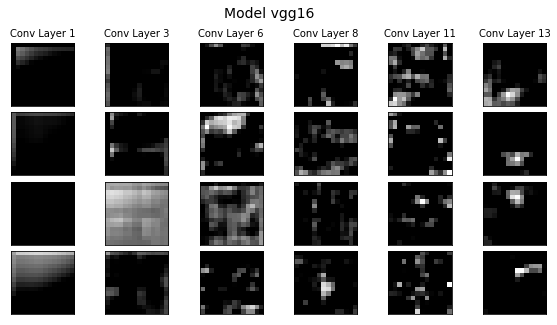

In [5]:
fig, axarrs = plt.subplots(ncols=len(layerIdxs),nrows=4, figsize=(10,5), 
                          gridspec_kw={'wspace': 0.1, 'hspace': 0.1}, 
                          sharey=True, sharex=True, squeeze=True)
fig.suptitle('Model %s' % (modelName), fontsize=14)
for idxOut, idx in enumerate(range(4)):
    axarr = [axarrs[idxOut][i]for i in range(len(layerIdxs))]
    plt.subplots_adjust(wspace=0.08)
    for j,ax in zip(layerIdxs, axarr):
        plt.sca(ax)
        if idxOut == 0:
            plt.title('Conv Layer %d%s' % (j+1,''),fontsize=10)
        plt.imshow(outputsReLU[j][0,idx,:,:],cmap="gray")
        plt.xticks([])
        plt.yticks([])
fig.subplots_adjust(hspace=0.5,wspace=0.5)
plt.savefig('figs/Activation Maps-%s.jpg' % (modelName), bbox_inches='tight')

#### Histograms act values (normalized) distribution

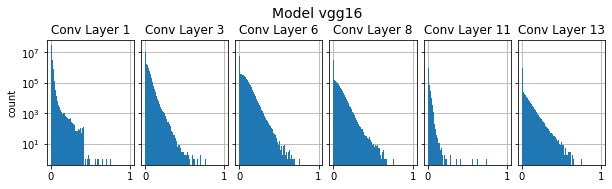

In [6]:
#histogram 
nonZeroOnly = False # select whether to exclude zero values
_, axarr = plt.subplots(ncols=len(layerIdxs), sharey=True, figsize=(10,2.3), squeeze=True)
_.suptitle('Model %s' % (modelName), fontsize=14,y=1.08)
plt.subplots_adjust(wspace=0.08)

for idx, ax in zip(layerIdxs, axarr):
    ax.set_title('Conv Layer %d%s' % (idx+1,''))
    histtmp = outputsReLU[idx].view(-1).numpy()
    if nonZeroOnly:
        histtmp = histtmp[histtmp.nonzero()]
    bins = np.linspace(0,1,81)
    ax.hist(histtmp, bins=bins, log=True)
    ax.grid(True)
axarr[0].set_ylabel('count')

plt.savefig('figs/fm_histogram-%s.jpg' % modelName, bbox_inches='tight', pad_inches=0.0)

## Compressing Activation Maps

### Zero Value Compression (ZVC)

In [7]:
zvc_data = []
# Layer, Sparsity, Compression Ratio, Compressed Size, Actual Size

for i in convlayerIdxs:
    layer='Conv Layer %d' % (i+1)
    sparsity=analyzer.getSparsity(outputsReLU[i])
    compress_ratio, compressed_size, actual_size = analyzer.ComprStats(outputsReLU[i], quant='fixed8', compressor=lambda x: ZVC(
                                          x, wordwidth=getWW('fixed8')))
    
    zvc_data.append([layer, sparsity, compress_ratio, compressed_size, actual_size])

zvc_df = pd.DataFrame(zvc_data, columns=['Layer', 'Sparsity', 'Compression Ratio','Compressed Size', 'Actual Size'])
    
zvc_df.to_csv('results/ZVC-%s.csv'%modelName, index=False) 

###  Zero Run Length Encoding (ZeroRLE)

In [11]:
zrle_data = []
# Layer, Sparsity, Compression Ratio, Compressed Size, Actual Size

for i in convlayerIdxs:
    layer='Conv Layer %d' % (i+1)
    sparsity=analyzer.getSparsity(outputsReLU[i])
    compress_ratio, compressed_size, actual_size = analyzer.ComprStats(outputsReLU[i], quant='fixed8', compressor=lambda x: zeroRLE(
                                          x, wordwidth=getWW('fixed8'),maxZeroBurstLen=63))
    
    zrle_data.append([layer, sparsity, compress_ratio, compressed_size, actual_size])

zrle_df = pd.DataFrame(zrle_data, columns=['Layer', 'Sparsity', 'Compression Ratio','Compressed Size', 'Actual Size'])

zrle_df.to_csv('results/zero_RLE-%s.csv'%modelName, index=False) 

###  Grid Based Zero Run Length Encoding (ZeroRLE)

In [15]:
grle_data = []
# Layer, Sparsity, Compression Ratio, Compressed Size, Actual Size

for i in convlayerIdxs:
    layer='Conv Layer %d' % (i+1)
    sparsity=analyzer.getSparsity(outputsReLU[i])
    compress_ratio, compressed_size, actual_size = analyzer.ComprStats(outputsReLU[i], quant='fixed8', compressor=lambda x: GRLE_wo(
                                          x,tileSize=4,maxZeroBurstLen=63),flat=False)
    
    grle_data.append([layer, sparsity, compress_ratio, compressed_size, actual_size])

grle_df = pd.DataFrame(grle_data, columns=['Layer', 'Sparsity', 'Compression Ratio','Compressed Size', 'Actual Size'])
    
grle_df.to_csv('results/GRLE-%s.csv'%modelName, index=False)

###  Plotting Results

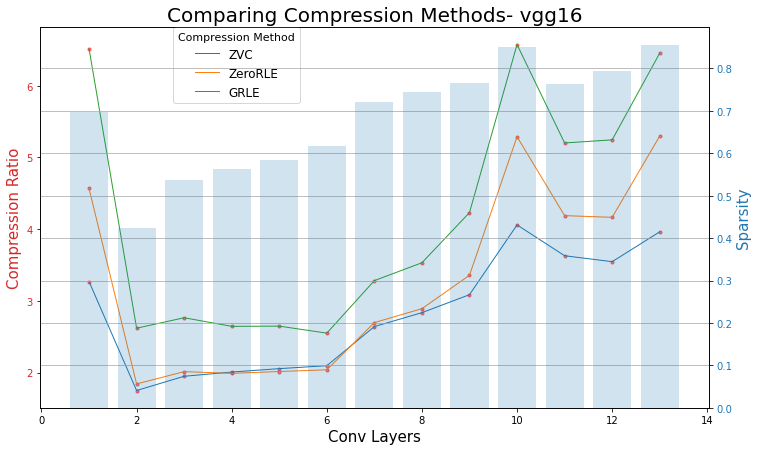

In [31]:
comp=['ZVC','ZeroRLE','GRLE']
layers=np.arange(1,len(convlayerIdxs)+1,1)
color1 = 'tab:red'
color2 = 'tab:blue'
fig, ax1 = plt.subplots(figsize = (12, 7))
plt.title("Comparing Compression Methods- %s"% modelName,fontsize=20)
ax1.plot(layers,zvc_df['Compression Ratio'],label=comp[0],lw=1,alpha=1)
ax1.scatter(layers,zvc_df['Compression Ratio'],color='r',s=10,alpha=0.5)

ax1.plot(layers,zrle_df['Compression Ratio'],label=comp[1],lw=1,alpha=1)
ax1.scatter(layers,zrle_df['Compression Ratio'],color='r',s=10,alpha=0.5)

ax1.plot(layers,grle_df['Compression Ratio'],label=comp[2],lw=1,alpha=1)
ax1.scatter(layers,grle_df['Compression Ratio'],color='r',s=10,alpha=0.5)

plt.legend(title="Compression Method",title_fontsize=11,fontsize=12,loc=(0.2, 0.8))#"upper left")
ax1.set_xlabel("Conv Layers",fontsize=20)
ax1.set_ylabel("Compression Ratio",fontsize=15,color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(layers, zvc_df['Sparsity'],alpha=0.2)
ax2.set_ylabel('Sparsity',fontsize=15,color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax1.set_xlabel("Conv Layers",fontsize=15) 
plt.grid()
plt.savefig('figs/compress_compare-%s.jpg' % modelName, bbox_inches='tight', pad_inches=0.0)